In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

class DQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DQN, self).__init__()
        self.line1 = nn.Linear(num_inputs, 64)
        self.line2 = nn.Linear(64, 32)
        self.line3 = nn.Linear(32, num_outputs)

    def forward(self, x):
        x = torch.sigmoid(self.line1(x))
        x = F.relu(self.line2(x))
        x = self.line3(x)
        return x
    
nn = DQN(8,4)
nn.load_state_dict(torch.load('/Users/valarian/SJTU/SJTU/毕业论文/Data/result/NNparams_close_to_realityDQN400_4_20000epi.pkl'))

#r = nn(torch.from_numpy(np.array([40.0,50.0,60.0,70.0,0.0,0.0,0.0,0.0])).float())
r = nn(np.array([40.0,50.0,60.0,70.0,0.0,0.0,0.0,0.0])).float()

In [131]:
r

tensor([534.3033, 520.1340, 517.5049, 514.2177], grad_fn=<AddBackward0>)

In [159]:
class BikeNet():
    def __init__(self, N, A, R, Q, repair, warmup_time, run_time, start_position=0, n_epi=5):
        self.N = N
        self.A = A
        self.R = R
        self.Q = Q
        self.repair = repair
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.car = start_position
        self.edge = int(self.A**0.5)
        self.areas = list(range(A + 1))

        self.n_epi = n_epi

        self.reset()

        #self.create_instances()

    def reset(self):
        self.T = 0
        self.carrier_position = self.car
        self.state = [int(self.N / self.A)] * self.A + [0] * self.A
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            heapq.heappush(self.scheduler, [random.expovariate(self.R[i][0]), -1, i])
        heapq.heapify(self.scheduler)
        return np.array(self.state.copy())

    def warmup(self):
        self.reset()

        while self.T < self.warmup_time:
            self.step(random.randint(0,self.A-1), 0)

        self.T = self.warmup_time
        # return np.array(s.copy())

    def create_instances(self):
        log_by_step = []
        log_by_epi = []
        for i in tqdm(range(self.n_epi)):
            self.warmup()
            step_count = 0
            sum_loss, sum_cus = 0,0
            while step_count < MAX_STEP:
                s = self.state
                action = int(nn(torch.from_numpy(np.array(s)).float()).argmax())
                re = self.step(action, 1)
                cus, done, loss = re[1], re[2], re[3]
                rate_broken = sum(self.state[4:8])/self.N
                log_by_step.append([i+1]+s+[action]+self.state+[cus]+[loss]+[rate_broken] + [self.T])
                sum_loss += loss
                sum_cus += cus
                step_count += 1
            log_by_epi.append([sum_loss, sum_cus])
        return log_by_epi
#         pd.DataFrame(log_by_step).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_step_4_80part1.csv')
#         pd.DataFrame(log_by_epi).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_epi_4_80part1.csv')


        # self.T = self.warmup_time
        # return np.array(s.copy())


    def get_distance(self, start, end):
        dist = abs(start % (self.edge) - end % (self.edge)) + abs(
            start // (self.edge) - end // (self.edge))
        return dist
    
    def step(self, action, not_warm):
        loss = 0
        cus = 0
        # time for carrier to take the action and repair one bicycle
        dist = self.get_distance(self.carrier_position, action)
        t = dist * 2
        if self.state[action + self.A] > 0:
            t_cursor = self.T + t + self.repair
        else:
            t_cursor = self.T + t

        event = self.scheduler[0]
        self.T, kind, location = event[0], event[1], event[2]

        # update the atate of QN during the tansformation time
        while self.T < t_cursor:
            # 车到达
            if kind == 1:
                self.state[location] += 1
                heapq.heappop(self.scheduler)
            else:# 顾客到达
                if self.state[location] == 0:  # 但没车
                    loss += 1
                    #rewards -= 1
                    heapq.heappop(self.scheduler)
                else:
                    target = np.random.choice(self.areas, 1, p=self.Q[location])[0]
                    if target == self.A:  # 顾客到达，发现是坏车
                        self.state[location] -= 1
                        self.state[location + self.A] += 1
                        continue
                    else:  # 顾客到达，顺利骑行
                        cus += 1
                        self.state[location] -= 1
                        heapq.heappop(self.scheduler)
                        next_time = random.expovariate(self.R[location][1]) + self.T
                        heapq.heappush(self.scheduler, [next_time, 1, target])
                next_time = random.expovariate(self.R[location][0]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, location])

            if self.scheduler:
                event = self.scheduler[0]
                self.T, kind, location = event[0], event[1], event[2]
            else:
                break

        if not_warm == 1:
            if self.state[action + self.A] > 0:
                self.state[action] += 1
                self.state[action + self.A] -= 1

        self.carrier_position = action
        self.T = t_cursor

        s_ = np.array(self.state)

        #if self.T <= self.time_limit and self.scheduler:
        return s_, cus, 0, loss
        #else:
        #    return s_, cus, 1, t

        
MAX_STEP = 24
        
if __name__ == '__main__':
    random.seed(0)
    N = 400  # total number of bikes in the QN
    A = 4  # A for areas, indicates the number of areas and the action space
    R = {}  # [customer_arrval, ride]
    for i in range(A): R[i] = [0.5, 0.2]
    rate = 0.073
    Q = [[0.1255, 0.251, 0.251, 0.1255, 0.247],
     [0.251, 0.1255, 0.1255, 0.251, 0.247],
     [0.251, 0.1255, 0.1255, 0.251, 0.247],
     [0.1255, 0.251, 0.251, 0.1255, 0.247]]
    t_repair = 12
    warmup_time = 60
    run_time = 180

    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  Q=Q,
                  repair=t_repair,
                  warmup_time=warmup_time,
                  run_time=run_time,
                  start_position=0,
                  n_epi=500)
    result = env.create_instances()
    # print(env.warmup(RL))
    # print(RL.memory)
    # r = 0
    # while env.T<680:
    #     r += env.step(random.randint(0, 3))[1]
    # print(env.state)
    # print(env.c)
    # print(env.T)
    # # print(env.step(1))
    # print(env.scheduler)

100%|██████████| 500/500 [00:17<00:00, 29.33it/s]


In [151]:
import matplotlib.pyplot as plt

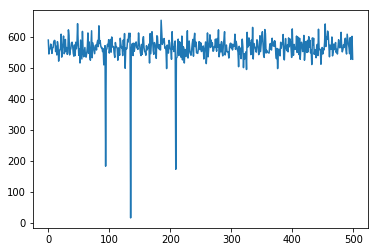

In [160]:
result = np.array(result)
served = result[:, 1]
plt.plot(served)

In [172]:
np.average(served[250:])

567.192

In [100]:
rate = 0.247
Q = np.array([[0.15,0.3,0.3,0.15],
             [0.3,0.15,0.15,0.3],
             [0.3,0.15,0.15,0.3],
             [0.15,0.3,0.3,0.15]])
Q = [np.append(x/sum(x)*(1-rate), rate) for x in Q]
Q = [list(q) for q in Q]
Q

[[0.1255, 0.251, 0.251, 0.1255, 0.247],
 [0.25100000000000006,
  0.12550000000000003,
  0.12550000000000003,
  0.25100000000000006,
  0.247],
 [0.25100000000000006,
  0.12550000000000003,
  0.12550000000000003,
  0.25100000000000006,
  0.247],
 [0.1255, 0.251, 0.251, 0.1255, 0.247]]

In [102]:
Q = [[0.1255, 0.251, 0.251, 0.1255, 0.247],
 [0.2510,
  0.1255,
  0.1255,
  0.2510,
  0.247],
 [0.2510,
  0.1255,
  0.1255,
  0.2510,
  0.247],
 [0.1255, 0.251, 0.251, 0.1255, 0.247]]
Q

[[0.1255, 0.251, 0.251, 0.1255, 0.247],
 [0.251, 0.1255, 0.1255, 0.251, 0.247],
 [0.251, 0.1255, 0.1255, 0.251, 0.247],
 [0.1255, 0.251, 0.251, 0.1255, 0.247]]

# Generate common customer serve number

In [161]:
import heapq
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

class Carrier():
    def __init__(self, capacity):
        self.capacity = capacity
        self.normal_bike = 0
        self.broken_bike = 0
    
    def pick_normal(self):
        self.normal_bike = self.capacity
        
    def drop_normal(self, rate):
        drop_n = min(int(rate * self.capacity), self.normal_bike)
        self.normal_bike -= drop_n
        return drop_n

    def pick_broken(self, n_broken):
        self.broken_bike += n_broken
    
    def drop_broken(self):
        self.broken_bike = 0

class BikeNet():
    def __init__(self, N, A, R, Q, pick, warmup_time, run_time, start_position=0, n_epi=5):
        self.N = N
        self.A = A
        self.R = R
        self.Q = Q
        self.pick = pick
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.car_position = start_position
        self.edge = int(self.A**0.5)
        self.areas = list(range(A + 1))

        self.n_epi = n_epi
        
        self.car = Carrier(CARRIER_CAPACITY)
        
        self.reset()

        #self.create_instances()
    
    def simulate(self):
        r = self.create_instances()
        return r
    
    def reset(self):
        self.T = 0
        self.carrier_position = self.car_position
        self.state = [int(self.N / self.A)] * self.A + [0] * self.A
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            heapq.heappush(self.scheduler, [random.expovariate(self.R[i][0]), -1, i])
        heapq.heapify(self.scheduler)
        return np.array(self.state.copy())

    def warmup(self):
        self.reset()

        while self.T < self.warmup_time:
            self.step(random.randint(0,self.A-1), 0, 0)

        self.T = self.warmup_time
        # return np.array(s.copy())

    def create_instances(self):
        log_by_step = []
        log_by_epi = []
        broken_rate = []
        for i in tqdm(range(self.n_epi)):
            self.warmup()
            step_count = 0
            b_rate = 0
            self.car.pick_normal()
            sum_loss, sum_cus = 0,0
            while step_count < MAX_STEP:
                s = self.state
                if self.car.broken_bike != self.car.capacity:
                    action = (self.carrier_position + 1) % self.A
                    re = self.step(action, 1, step_count)
                else:
                    action = self.A
                    re = self.step(action, 1, step_count)
                    
                
                rate_broken = sum(self.state[4:8])/self.N
                cus, done, loss = re[1], re[2], re[3]
                log_by_step.append([i+1] + [rate_broken] + [self.T])
                sum_loss += loss
                sum_cus += cus
                step_count += 1
            log_by_epi.append([sum_cus, sum_loss])
        

        return log_by_epi
#         pd.DataFrame(log_by_step).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_step_4_80part1.csv')
#         pd.DataFrame(log_by_epi).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_epi_4_80part1.csv')


        # self.T = self.warmup_time
        # return np.array(s.copy())


    def get_distance(self, start, end):
        dist = abs(start % (self.edge) - end % (self.edge)) + abs(
            start // (self.edge) - end // (self.edge))
        return dist
    
    def step(self, action, not_warm, step_count):
        loss = 0
        cus = 0
        # time for carrier to take the action and repair one bicycle
        if action != self.A:
            dist = self.get_distance(self.carrier_position, action)
            t = dist * 2
            if (self.state[action + self.A]>0&self.car.broken_bike<self.car.capacity) or \
                (self.state[action]>0&self.car.normal_bike>0):
                t_cursor = self.T + t + self.pick
            else:
                t_cursor = self.T + t
        else:
            t_cursor = self.T + (1+2)/2 * 2 + 10 + (1+2)/2 * 2

        event = self.scheduler[0]
        self.T, kind, location = event[0], event[1], event[2]

        # update the atate of QN during the tansformation time
        while self.T < t_cursor:
            # 车到达
            if kind == 1:
                self.state[location] += 1
                heapq.heappop(self.scheduler)
            else:# 顾客到达
                if self.state[location] == 0:  # 但没车
                    loss += 1
                    #print('here\'s a loss')
                    #rewards -= 1
                    heapq.heappop(self.scheduler)
                else:
                    target = np.random.choice(self.areas, 1, p=self.Q[location])[0]
                    if target == self.A:  # 顾客到达，发现是坏车
                        self.state[location] -= 1
                        self.state[location + self.A] += 1
                        continue
                    else:  # 顾客到达，顺利骑行
                        cus += 1
                        self.state[location] -= 1
                        heapq.heappop(self.scheduler)
                        next_time = random.expovariate(self.R[location][1]) + self.T
                        heapq.heappush(self.scheduler, [next_time, 1, target])
                next_time = random.expovariate(self.R[location][0]*0.988**step_count) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, location])

            if self.scheduler:
                event = self.scheduler[0]
                self.T, kind, location = event[0], event[1], event[2]
            else:
                break

        if not_warm == 1:
            if action != self.A:
                self.state[action] += self.car.drop_normal(self.R[action][0]/sum(self.R[action]))
                broken_to_pick = min(self.car.capacity-self.car.normal_bike-self.car.broken_bike, self.state[action+self.A])
                self.car.pick_broken(broken_to_pick)
                self.state[action+self.A] -= broken_to_pick
                self.carrier_position = action
            else:
                self.car.drop_broken()
                self.car.pick_normal()
                self.carrier_position = self.carrier_position
        
        self.T = t_cursor

        s_ = np.array(self.state)

        #if self.T <= self.time_limit and self.scheduler:
        return s_, cus, 0, loss
        #else:
        #    return s_, cus, 1, t

        
MAX_STEP = 24
        
if __name__ == '__main__':
    random.seed(0)
    N = 400  # total number of bikes in the QN
    A = 4  # A for areas, indicates the number of areas and the action space
    R = {}  # [customer_arrval, ride]
    for i in range(A): R[i] = [0.5, 0.2]
    BROKEN_RATE = 0.15
    CARRIER_CAPACITY = 12
    rate = 0.1
    rate_ = 0.5
    t_pick = 6
    warmup_time = 60
    run_time = 180

    Q = [[0.1255, 0.251, 0.251, 0.1255, 0.247],
         [0.251, 0.1255, 0.1255, 0.251, 0.247],
         [0.251, 0.1255, 0.1255, 0.251, 0.247],
         [0.1255, 0.251, 0.251, 0.1255, 0.247]]
    # Q = [[0,0.9,0.1], [0.9,0,0.1]]


    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  Q=Q,
                  pick=t_pick,
                  warmup_time=warmup_time,
                  run_time=run_time,
                  start_position=0,
                  n_epi=500)

    base = env.simulate()



100%|██████████| 500/500 [00:13<00:00, 37.98it/s]


In [162]:
a = np.array(base)

In [174]:
np.average(a[:,0]), np.var(a[:,0])**0.5

(471.9, 21.809585048780733)

In [177]:
np.average(served[250:]), np.var(served[250:])**0.5

(567.192, 25.024051150842862)

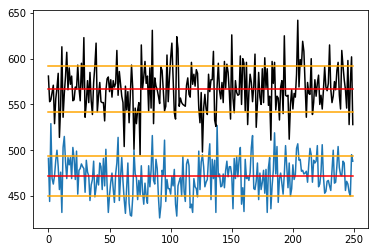

In [180]:
plt.plot(a[250:,0])
plt.plot(served[250:], color='0')
plt.plot([471.9+21.81]*250, color='orange')
plt.plot([471.9-21.81]*250, color='orange')
plt.plot([471.9]*250, color='r')
plt.plot([567.2+25.02]*250, color='orange')
plt.plot([567.2-25.02]*250, color='orange')
plt.plot([567.2]*250, color='r')

# Find the broken transition rate to make the overall broken rates equals to 15%
# With carrier rabalancing

In [ ]:
import heapq
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

class Carrier():
    def __init__(self, capacity):
        self.capacity = capacity
        self.normal_bike = 0
        self.broken_bike = 0
    
    def pick_normal(self):
        self.normal_bike = self.capacity
        
    def drop_normal(self, rate):
        drop_n = min(int(rate * self.capacity), self.normal_bike)
        self.normal_bike -= drop_n
        return drop_n

    def pick_broken(self, n_broken):
        self.broken_bike += n_broken
    
    def drop_broken(self):
        self.broken_bike = 0

class BikeNet():
    def __init__(self, N, A, R, Q, pick, warmup_time, run_time, start_position=0, n_epi=5):
        self.N = N
        self.A = A
        self.R = R
        self.Q = Q
        self.pick = pick
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.car_position = start_position
        self.edge = int(self.A**0.5)
        self.areas = list(range(A + 1))

        self.n_epi = n_epi
        
        self.car = Carrier(CARRIER_CAPACITY)
        
        self.reset()

        #self.create_instances()
    
    def simulate(self):
        r = self.create_instances()
        return r
    
    def reset(self):
        self.T = 0
        self.carrier_position = self.car_position
        self.state = [int(self.N / self.A)] * self.A + [0] * self.A
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            heapq.heappush(self.scheduler, [random.expovariate(self.R[i][0]), -1, i])
        heapq.heapify(self.scheduler)
        return np.array(self.state.copy())

    def warmup(self):
        self.reset()

        while self.T < self.warmup_time:
            self.step(random.randint(0,self.A-1), 0, 0)

        self.T = self.warmup_time
        # return np.array(s.copy())

    def create_instances(self):
        log_by_step = []
        log_by_epi = []
        sum_loss, sum_cus =0, 0
        broken_rate = []
        for i in tqdm(range(self.n_epi)):
            self.warmup()
            step_count = 0
            b_rate = 0
            self.car.pick_normal()
            #sum_loss, sum_cus = 0,0
            while step_count < MAX_STEP:
                s = self.state
                if self.car.broken_bike != self.car.capacity:
                    action = (self.carrier_position + 1) % self.A
                    re = self.step(action, 1, step_count)
                else:
                    action = self.A
                    re = self.step(action, 1, step_count)
                    
                
                rate_broken = sum(self.state[4:8])/self.N
                cus, done, loss = re[1], re[2], re[3]
                log_by_step.append([i+1] + [rate_broken] + [self.T])
                sum_loss += loss
                sum_cus += cus
                step_count += 1
            log_by_epi.append([sum_loss, sum_cus])
        
        result = []
        self.df1 = pd.DataFrame(log_by_step)
#         print(df1)
        atm = 0
        for i in range(1,self.n_epi+1):
            temp = self.df1[self.df1[0]==i]
            tm = temp[2].max()
            atm += tm
            temp['seg'] = temp[2].diff()
            temp.iloc[0,3] = 0
            result.append(sum(temp.seg*temp[1])/tm)
        print(atm/self.n_epi)
        return np.average(np.average(result))
#         pd.DataFrame(log_by_step).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_step_4_80part1.csv')
#         pd.DataFrame(log_by_epi).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_epi_4_80part1.csv')


        # self.T = self.warmup_time
        # return np.array(s.copy())


    def get_distance(self, start, end):
        dist = abs(start % (self.edge) - end % (self.edge)) + abs(
            start // (self.edge) - end // (self.edge))
        return dist
    
    def step(self, action, not_warm, step_count):
        loss = 0
        cus = 0
        # time for carrier to take the action and repair one bicycle
        if action != self.A:
            dist = self.get_distance(self.carrier_position, action)
            t = dist * 2
            if (self.state[action + self.A]>0&self.car.broken_bike<self.car.capacity) or \
                (self.state[action]>0&self.car.normal_bike>0):
                t_cursor = self.T + t + self.pick
            else:
                t_cursor = self.T + t
        else:
            t_cursor = self.T + (1+2)/2 * 2 + 10 + (1+2)/2 * 2

        event = self.scheduler[0]
        self.T, kind, location = event[0], event[1], event[2]

        # update the atate of QN during the tansformation time
        while self.T < t_cursor:
            # 车到达
            if kind == 1:
                self.state[location] += 1
                heapq.heappop(self.scheduler)
            else:# 顾客到达
                if self.state[location] == 0:  # 但没车
                    loss += 1
                    #rewards -= 1
                    heapq.heappop(self.scheduler)
                else:
                    target = np.random.choice(self.areas, 1, p=self.Q[location])[0]
                    if target == self.A:  # 顾客到达，发现是坏车
                        self.state[location] -= 1
                        self.state[location + self.A] += 1
                        continue
                    else:  # 顾客到达，顺利骑行
                        cus += 1
                        self.state[location] -= 1
                        heapq.heappop(self.scheduler)
                        next_time = random.expovariate(self.R[location][1]) + self.T
                        heapq.heappush(self.scheduler, [next_time, 1, target])
                next_time = random.expovariate(self.R[location][0]*0.988**step_count) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, location])

            if self.scheduler:
                event = self.scheduler[0]
                self.T, kind, location = event[0], event[1], event[2]
            else:
                break

        if not_warm == 1:
            if action != self.A:
                self.state[action] += self.car.drop_normal(self.R[action][0]/sum(self.R[action]))
                broken_to_pick = min(self.car.capacity-self.car.normal_bike-self.car.broken_bike, self.state[action+self.A])
                self.car.pick_broken(broken_to_pick)
                self.state[action+self.A] -= broken_to_pick
                self.carrier_position = action
            else:
                self.car.drop_broken()
                self.car.pick_normal()
                self.carrier_position = self.carrier_position
        
        self.T = t_cursor

        s_ = np.array(self.state)

        #if self.T <= self.time_limit and self.scheduler:
        return s_, cus, 0, loss
        #else:
        #    return s_, cus, 1, t

        
MAX_STEP = 24
        
if __name__ == '__main__':
    random.seed(0)
    N = 400  # total number of bikes in the QN
    A = 4  # A for areas, indicates the number of areas and the action space
    R = {}  # [customer_arrval, ride]
    for i in range(A): R[i] = [0.5, 0.2]
    BROKEN_RATE = 0.15
    CARRIER_CAPACITY = 12
    rate = 0.1
    rate_ = 0.5
    t_pick = 6
    warmup_time = 60
    run_time = 180
    
    alpha = 0.1
    while int(rate_*100)/100 != BROKEN_RATE:

        Q = np.array([[0.15,0.3,0.3,0.15],
             [0.3,0.15,0.15,0.3],
             [0.3,0.15,0.15,0.3],
             [0.15,0.3,0.3,0.15]])
        Q = [np.append(x/sum(x)*(1-rate), rate) for x in Q]
        # Q = [[0,0.9,0.1], [0.9,0,0.1]]


        env = BikeNet(N=N,
                      A=A,
                      R=R,
                      Q=Q,
                      pick=t_pick,
                      warmup_time=warmup_time,
                      run_time=run_time,
                      start_position=0,
                      n_epi=100)
        
        rate_ = env.simulate()
        rate = rate - alpha*(rate_ - BROKEN_RATE)
        print(rate, rate_)
        # print(env.warmup(RL))
        # print(RL.memory)
        # r = 0
        # while env.T<680:
        #     r += env.step(random.randint(0, 3))[1]
        # print(env.state)
        # print(env.c)
        # print(env.T)
        # # print(env.step(1))
        # print(env.scheduler)




In [ ]:
env.df1

# Find the broken transition rate to make the overall broken rates equals to 15%
# Under circumstance of no carrier rabalancing

In [ ]:
import heapq
import random
import numpy as np
import pandas as pd
from tqdm import tqdm


class BikeNet():
    def __init__(self, N, A, R, Q, repair, warmup_time, run_time, start_position=0, n_epi=5):
        self.N = N
        self.A = A
        self.R = R
        self.Q = Q
        self.repair = repair
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.car = start_position
        self.edge = int(self.A**0.5)
        self.areas = list(range(A + 1))

        self.n_epi = n_epi

        self.reset()

        #self.create_instances()
    
    def simulate(self):
        r = self.create_instances()
        return r
    
    def reset(self):
        self.T = 0
        self.carrier_position = self.car
        self.state = [int(self.N / self.A)] * self.A + [0] * self.A
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            heapq.heappush(self.scheduler, [random.expovariate(self.R[i][0]), -1, i])
        heapq.heapify(self.scheduler)
        return np.array(self.state.copy())

    def warmup(self):
        self.reset()

        while self.T < self.warmup_time:
            self.step(random.randint(0,self.A-1), 0, 0)

        self.T = self.warmup_time
        # return np.array(s.copy())

    def create_instances(self):
        log_by_step = []
#         log_by_epi = []
        broken_rate = []
        for i in tqdm(range(self.n_epi)):
            self.warmup()
            step_count = 0
            b_rate = 0
            #sum_loss, sum_cus = 0,0
            while step_count < MAX_STEP:
                s = self.state
                action = random.randint(0,self.A-1)
                re = self.step(action, 1,step_count)
                rate_broken = sum(self.state[4:8])/self.N
#                 cus, done, loss = re[1], re[2], re[3]
                log_by_step.append([i+1] + [rate_broken] + [self.T])
#                 sum_loss += loss
#                 sum_cus += cus
                step_count += 1
#             log_by_epi.append([sum_loss, sum_cus])
        
        result = []
        df1 = pd.DataFrame(log_by_step)
#         print(df1)
        for i in range(1,self.n_epi+1):
            temp = df1[df1[0]==i]
            tm = temp[2].max()
            temp['seg'] = temp[2].diff()
            temp.iloc[0,3] = 0
            result.append(sum(temp.seg*temp[1])/tm)
        return np.average(np.average(result))
#         pd.DataFrame(log_by_step).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_step_4_80part1.csv')
#         pd.DataFrame(log_by_epi).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_epi_4_80part1.csv')


        # self.T = self.warmup_time
        # return np.array(s.copy())


    def get_distance(self, start, end):
        dist = abs(start % (self.edge) - end % (self.edge)) + abs(
            start // (self.edge) - end // (self.edge))
        return dist
    
    def step(self, action, not_warm, step_count):
        loss = 0
        cus = 0
        # time for carrier to take the action and repair one bicycle
        dist = self.get_distance(self.carrier_position, action)
        t = dist * 2
        if self.state[action + self.A] > 0:
            t_cursor = self.T + t + self.repair
        else:
            t_cursor = self.T + t

        event = self.scheduler[0]
        self.T, kind, location = event[0], event[1], event[2]

        # update the atate of QN during the tansformation time
        while self.T < t_cursor:
            # 车到达
            if kind == 1:
                self.state[location] += 1
                heapq.heappop(self.scheduler)
            else:# 顾客到达
                if self.state[location] == 0:  # 但没车
                    loss += 1
                    #rewards -= 1
                    heapq.heappop(self.scheduler)
                else:
                    target = np.random.choice(self.areas, 1, p=self.Q[location])[0]
                    if target == self.A:  # 顾客到达，发现是坏车
                        self.state[location] -= 1
                        self.state[location + self.A] += 1
                        continue
                    else:  # 顾客到达，顺利骑行
                        cus += 1
                        self.state[location] -= 1
                        heapq.heappop(self.scheduler)
                        next_time = random.expovariate(self.R[location][1]) + self.T
                        heapq.heappush(self.scheduler, [next_time, 1, target])
                next_time = random.expovariate(self.R[location][0]*0.988**step_count) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, location])

            if self.scheduler:
                event = self.scheduler[0]
                self.T, kind, location = event[0], event[1], event[2]
            else:
                break

        if not_warm == 1:
            if self.state[action + self.A] > 0:
                self.state[action] += 1
                self.state[action + self.A] -= 1

        self.carrier_position = action
        self.T = t_cursor

        s_ = np.array(self.state)

        #if self.T <= self.time_limit and self.scheduler:
        return s_, cus, 0, loss
        #else:
        #    return s_, cus, 1, t

        
MAX_STEP = 120
        
if __name__ == '__main__':
    random.seed(0)
    N = 400  # total number of bikes in the QN
    A = 4  # A for areas, indicates the number of areas and the action space
    R = {}  # [customer_arrval, ride]
    for i in range(A): R[i] = [0.5, 0.2]
    BROKEN_RATE = 0.15
    rate = 0.05
    rate_ = 0.5
    t_repair = 16
    warmup_time = 60
    run_time = 180
    
    alpha = 0.1
    while int(rate_*100)/100 != BROKEN_RATE:

        Q = np.array([[0.15,0.3,0.3,0.15],
             [0.3,0.15,0.15,0.3],
             [0.3,0.15,0.15,0.3],
             [0.15,0.3,0.3,0.15]])
        Q = [np.append(x/sum(x)*(1-rate), rate) for x in Q]
        # Q = [[0,0.9,0.1], [0.9,0,0.1]]


        env = BikeNet(N=N,
                      A=A,
                      R=R,
                      Q=Q,
                      repair=t_repair,
                      warmup_time=warmup_time,
                      run_time=run_time,
                      start_position=0,
                      n_epi=100)
        
        rate_ = env.simulate()
        rate = rate - alpha*(rate_ - BROKEN_RATE)
        print(rate, rate_)
        # print(env.warmup(RL))
        # print(RL.memory)
        # r = 0
        # while env.T<680:
        #     r += env.step(random.randint(0, 3))[1]
        # print(env.state)
        # print(env.c)
        # print(env.T)
        # # print(env.step(1))
        # print(env.scheduler)



# Origin instances generate program

In [ ]:

class BikeNet():
    def __init__(self, N, A, R, Q, repair, warmup_time, run_time, start_position=0, n_epi=5):
        self.N = N
        self.A = A
        self.R = R
        self.Q = Q
        self.repair = repair
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.car = start_position
        self.edge = int(self.A**0.5)
        self.areas = list(range(A + 1))

        self.n_epi = n_epi

        self.reset()

        self.create_instances()

    def reset(self):
        self.T = 0
        self.carrier_position = self.car
        self.state = [int(self.N / self.A)] * self.A + [0] * self.A
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            heapq.heappush(self.scheduler, [random.expovariate(self.R[i][0]), -1, i])
        heapq.heapify(self.scheduler)
        return np.array(self.state.copy())

    def warmup(self):
        self.reset()

        while self.T < self.warmup_time:
            self.step(random.randint(0,self.A-1), 0)

        self.T = self.warmup_time
        # return np.array(s.copy())

    def create_instances(self):
        log_by_step = []
        log_by_epi = []
        for i in tqdm(range(self.n_epi)):
            self.warmup()
            step_count = 0
            sum_loss, sum_cus = 0,0
            while step_count < MAX_STEP:
                s = self.state
                action = random.randint(0,self.A-1)
                re = self.step(action, 1)
                cus, done, loss = re[1], re[2], re[3]
                rate_broken = sum(self.state[4:8])/self.N
                log_by_step.append([i+1]+s+[action]+self.state+[cus]+[loss]+[rate_broken] + [self.T])
                sum_loss += loss
                sum_cus += cus
                step_count += 1
            log_by_epi.append([sum_loss, sum_cus])
        pd.DataFrame(log_by_step).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_step_4_80part1.csv')
        pd.DataFrame(log_by_epi).to_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_epi_4_80part1.csv')


        # self.T = self.warmup_time
        # return np.array(s.copy())


    def get_distance(self, start, end):
        dist = abs(start % (self.edge) - end % (self.edge)) + abs(
            start // (self.edge) - end // (self.edge))
        return dist
    
    def step(self, action, not_warm):
        loss = 0
        cus = 0
        # time for carrier to take the action and repair one bicycle
        dist = self.get_distance(self.carrier_position, action)
        t = dist * 2
        if self.state[action + self.A] > 0:
            t_cursor = self.T + t + self.repair
        else:
            t_cursor = self.T + t

        event = self.scheduler[0]
        self.T, kind, location = event[0], event[1], event[2]

        # update the atate of QN during the tansformation time
        while self.T < t_cursor:
            # 车到达
            if kind == 1:
                self.state[location] += 1
                heapq.heappop(self.scheduler)
            else:# 顾客到达
                if self.state[location] == 0:  # 但没车
                    loss += 1
                    #rewards -= 1
                    heapq.heappop(self.scheduler)
                else:
                    target = np.random.choice(self.areas, 1, p=self.Q[location])[0]
                    if target == self.A:  # 顾客到达，发现是坏车
                        self.state[location] -= 1
                        self.state[location + self.A] += 1
                        continue
                    else:  # 顾客到达，顺利骑行
                        cus += 1
                        self.state[location] -= 1
                        heapq.heappop(self.scheduler)
                        next_time = random.expovariate(self.R[location][1]) + self.T
                        heapq.heappush(self.scheduler, [next_time, 1, target])
                next_time = random.expovariate(self.R[location][0]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, location])

            if self.scheduler:
                event = self.scheduler[0]
                self.T, kind, location = event[0], event[1], event[2]
            else:
                break

        if not_warm == 1:
            if self.state[action + self.A] > 0:
                self.state[action] += 1
                self.state[action + self.A] -= 1

        self.carrier_position = action
        self.T = t_cursor

        s_ = np.array(self.state)

        #if self.T <= self.time_limit and self.scheduler:
        return s_, cus, 0, loss
        #else:
        #    return s_, cus, 1, t

        
MAX_STEP = 120
        
if __name__ == '__main__':
    random.seed(0)
    N = 400  # total number of bikes in the QN
    A = 4  # A for areas, indicates the number of areas and the action space
    R = {}  # [customer_arrval, ride]
    for i in range(A): R[i] = [0.5, 0.2]
    rate = 0.073
    Q = np.array([[0.15,0.3,0.3,0.15],
             [0.3,0.15,0.15,0.3],
             [0.3,0.15,0.15,0.3],
             [0.15,0.3,0.3,0.15]])
    Q = [np.append(x/sum(x)*(1-rate), rate) for x in Q]
    #Q = [[0.15,0.3,0.3,0.15,0.1],
    #     [0.3,0.15,0.15,0.3,0.1],
    #     [0.3,0.15,0.15,0.3,0.1],
    #     [0.15,0.3,0.3,0.15,0.1]]
    # Q = [[0,0.9,0.1], [0.9,0,0.1]]
    t_repair = 16
    warmup_time = 60
    run_time = 180

    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  Q=Q,
                  repair=t_repair,
                  warmup_time=warmup_time,
                  run_time=run_time,
                  start_position=0,
                  n_epi=500)

    # print(env.warmup(RL))
    # print(RL.memory)
    # r = 0
    # while env.T<680:
    #     r += env.step(random.randint(0, 3))[1]
    # print(env.state)
    # print(env.c)
    # print(env.T)
    # # print(env.step(1))
    # print(env.scheduler)



In [ ]:
df1 = rate_
for i in range(1,200+1):
    temp = df1[df1['2']==i]
    tm = temp['2'].max()
    temp['seg'] = temp['2'].diff()
    temp.iloc[0,3] = 0
    result.append(sum(temp.seg*temp['1'])/tm)

In [2]:
import pandas as pd

In [10]:
df1 = pd.read_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_step_4_80part1.csv', index_col=0)
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,59,23,39,2,2,6,7,6,3,59,23,39,2,2,6,7,6,22,1
1,1,60,24,38,3,2,6,7,6,3,60,24,38,3,2,6,7,6,3,0
2,1,60,28,39,0,2,5,7,6,1,60,28,39,0,2,5,7,6,11,3
3,1,62,30,36,1,2,5,7,5,3,62,30,36,1,2,5,7,5,11,2
4,1,59,34,35,0,2,4,7,5,1,59,34,35,0,2,4,7,5,14,3


In [11]:
df1.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
119995,2000,111,0,1,2,9,20,0,4,3,111,0,1,2,9,20,0,4,6,7
119996,2000,109,1,0,0,10,19,2,4,1,109,1,0,0,10,19,2,4,14,4
119997,2000,108,1,2,3,10,19,2,4,1,108,1,2,3,10,19,2,4,4,1
119998,2000,108,3,4,2,10,18,2,4,1,108,3,4,2,10,18,2,4,3,0
119999,2000,113,1,1,1,10,18,2,4,3,113,1,1,1,10,18,2,4,10,3


In [37]:
df2 = pd.read_csv('C:/Rebalancing/data/result/pytorchmodel/log_by_epi_4_80part1.csv', index_col=0)
df2.head()

,0,1
0,304,442
1,233,577
2,335,361
3,248,506
4,290,438


In [38]:
df2['0'].mean(), df2['1'].mean()

(296.5055, 485.884)

In [19]:
re = df.groupby(by='0').sum()

In [20]:
re['19'].mean()

345.2475